In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

In [2]:
df = pd.read_csv("ETT-small/ETTh1.csv")
df = df.set_index("date")
# keep only date and OT
df = df[["OT"]]
# normalize ot
# df["OT"] = df["OT"] - df["OT"].mean()
# df["OT"] = df["OT"] / df["OT"].std()
df.index = pd.to_datetime(df.index)

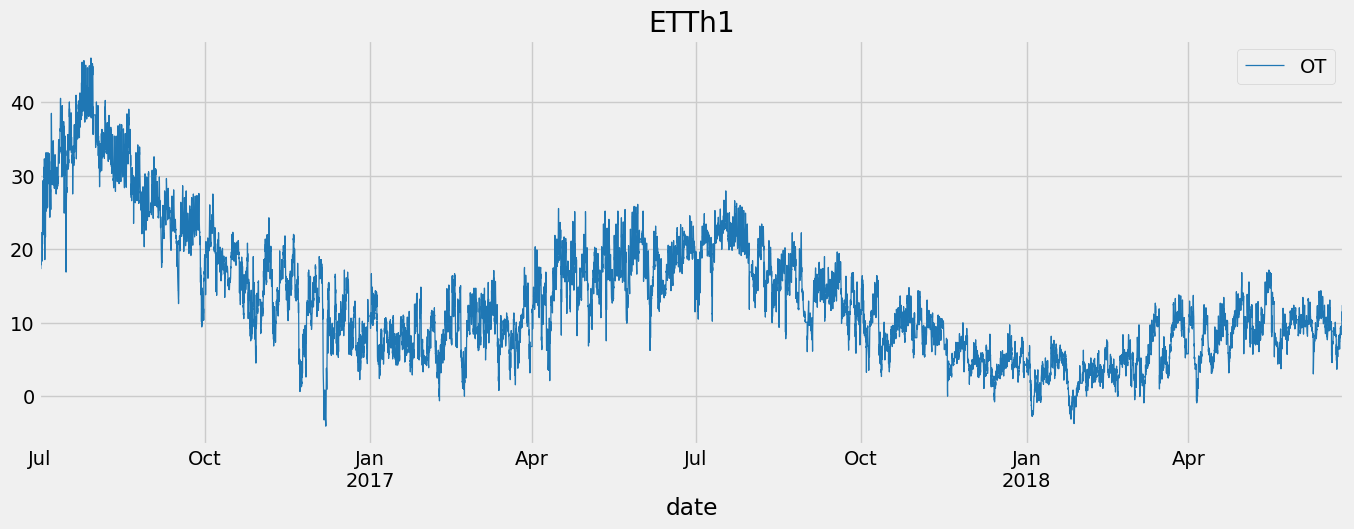

In [3]:
df.plot(figsize=(15, 5), color=color_pal[0], title="ETTh1", linewidth=0.9)
plt.show()

# Train / Test Split

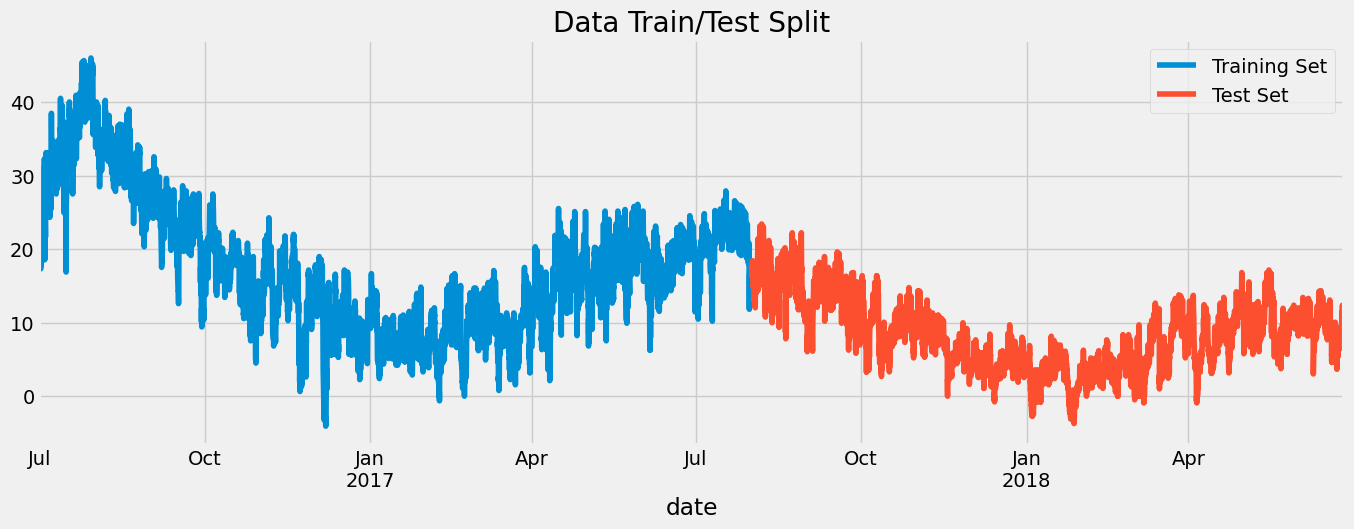

In [4]:
train = df.loc[df.index < "08-01-2017"]
test = df.loc[df.index >= "08-01-2017"]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training Set", title="Data Train/Test Split")
test.plot(ax=ax, label="Test Set")
ax.axvline("01-01-2015", color="black", ls="--")
ax.legend(["Training Set", "Test Set"])
plt.show()

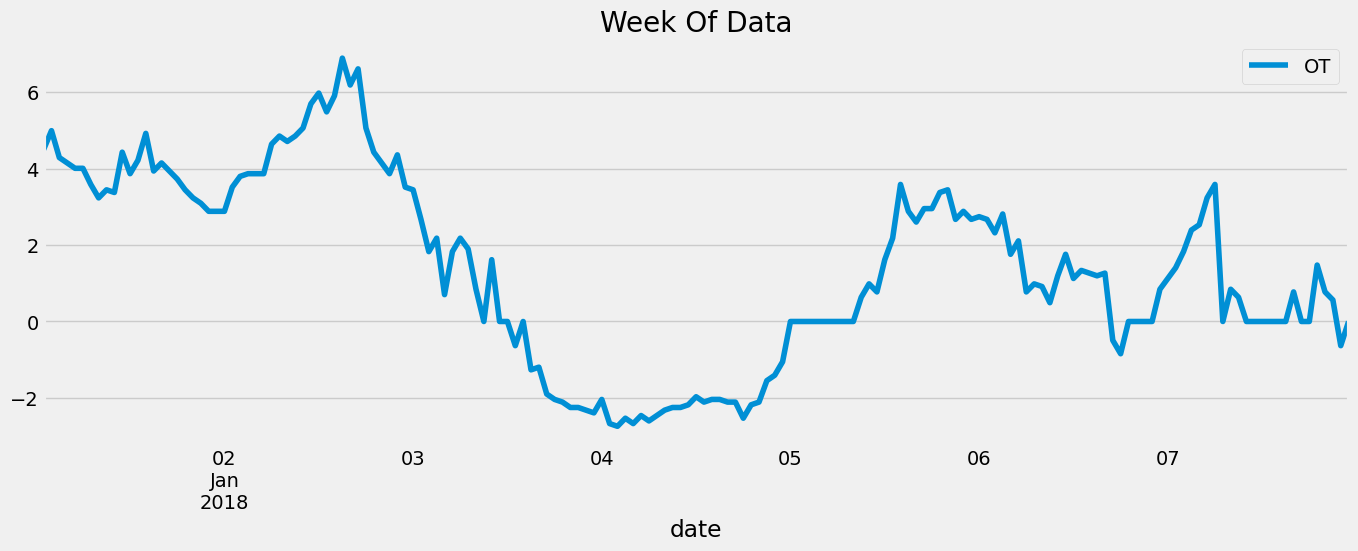

In [5]:
df.loc[(df.index > "01-01-2018") & (df.index < "01-08-2018")].plot(
    figsize=(15, 5), title="Week Of Data"
)
plt.show()

# Feature Creation

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    df["weekofyear"] = df.index.isocalendar().week
    return df


df = create_features(df)

# Visualize our Feature / Target Relationship

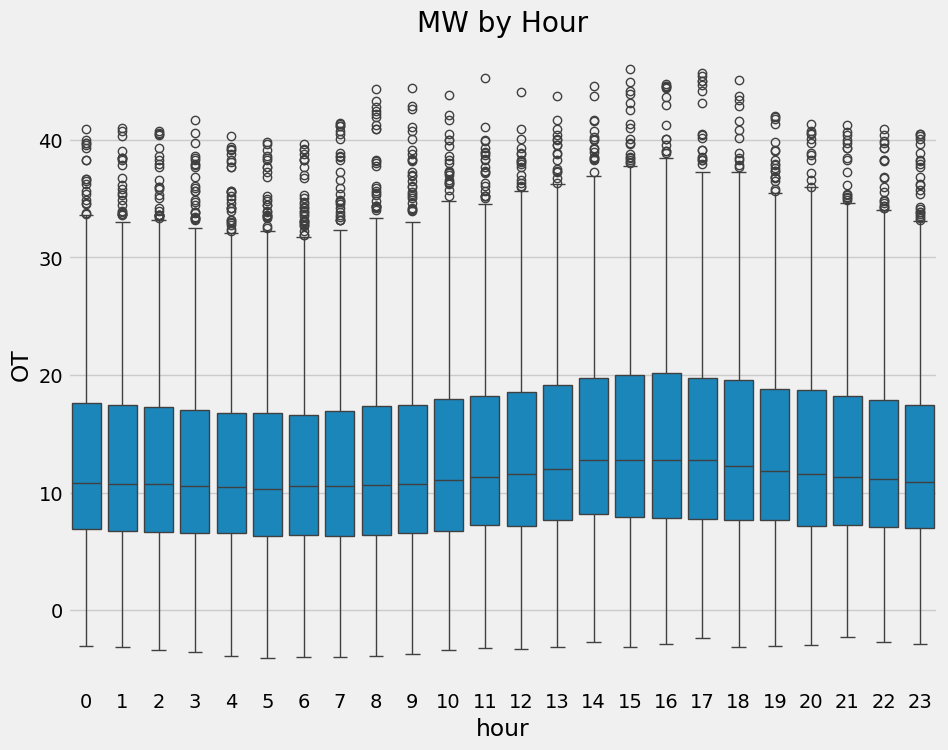

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x="hour", y="OT")
ax.set_title("MW by Hour")
plt.show()

/var/folders/1y/_q3nkgrn1f72ccrdw1wl1smh0000gn/T/ipykernel_37202/3957489444.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="month", y="OT", palette="Blues")


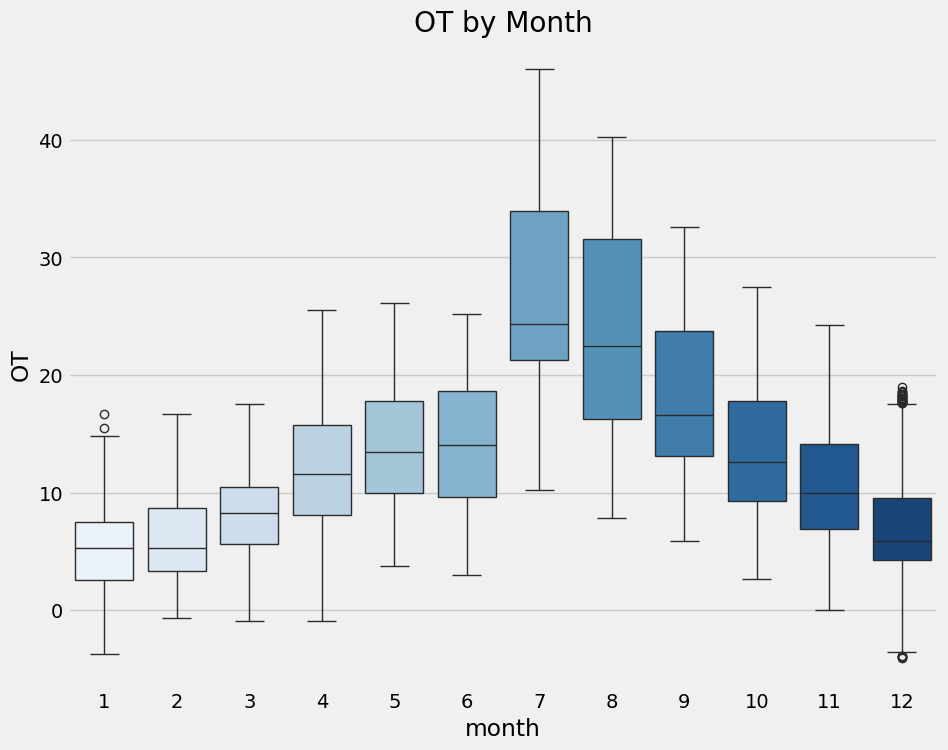

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x="month", y="OT", palette="Blues")
ax.set_title("OT by Month")
plt.show()

# Create our Model

In [9]:
train = create_features(train)
test = create_features(test)

FEATURES = ["dayofyear", "hour", "dayofweek", "quarter", "month", "year"]
TARGET = "OT"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [10]:
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=1000,
    early_stopping_rounds=1000,
    objective="reg:squarederror",
    max_depth=20,
    learning_rate=0.01,
)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:18.95314	validation_1-rmse:9.01490
[100]	validation_0-rmse:7.19143	validation_1-rmse:3.75359
[200]	validation_0-rmse:2.88348	validation_1-rmse:5.25835
[300]	validation_0-rmse:1.27351	validation_1-rmse:6.16115
[400]	validation_0-rmse:0.63100	validation_1-rmse:6.53529
[500]	validation_0-rmse:0.34487	validation_1-rmse:6.69242
[600]	validation_0-rmse:0.20307	validation_1-rmse:6.76262
[700]	validation_0-rmse:0.12434	validation_1-rmse:6.79602
[800]	validation_0-rmse:0.07837	validation_1-rmse:6.81278
[900]	validation_0-rmse:0.05007	validation_1-rmse:6.82087
[999]	validation_0-rmse:0.03234	validation_1-rmse:6.82528


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=1000,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importance

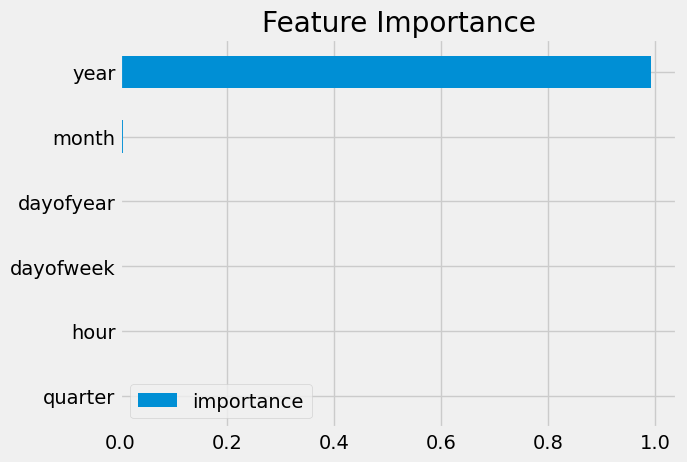

In [11]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"]
)
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

# Forecast on Test

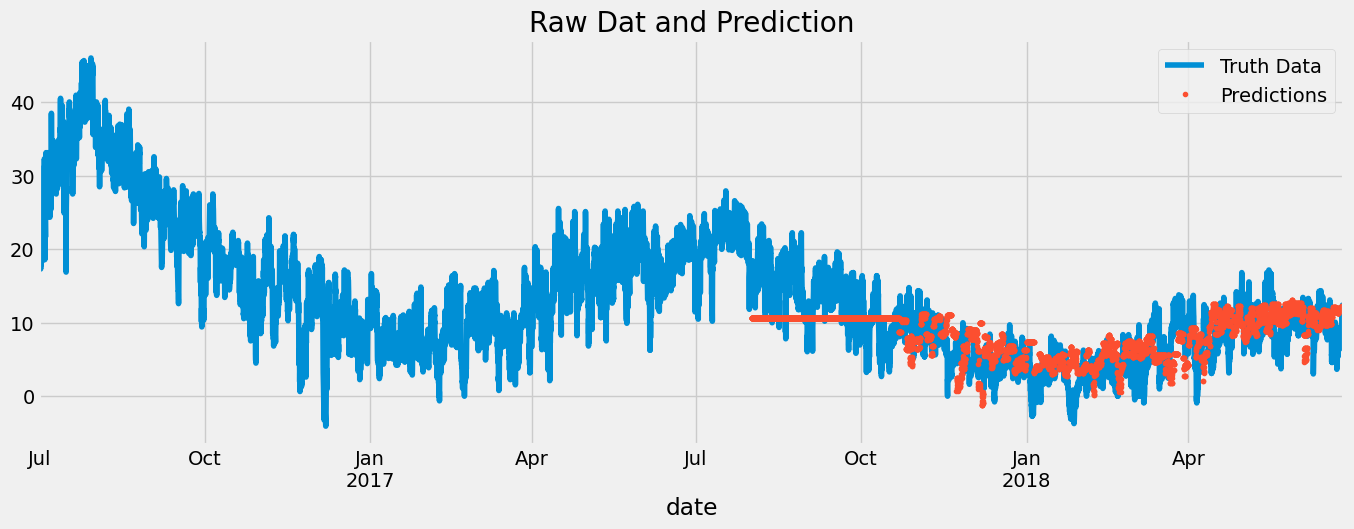

In [12]:
test["prediction"] = reg.predict(X_test)
df = df.merge(test[["prediction"]], how="left", left_index=True, right_index=True)
ax = df[["OT"]].plot(figsize=(15, 5))
df["prediction"].plot(ax=ax, style=".")
plt.legend(["Truth Data", "Predictions"])
ax.set_title("Raw Dat and Prediction")
plt.show()

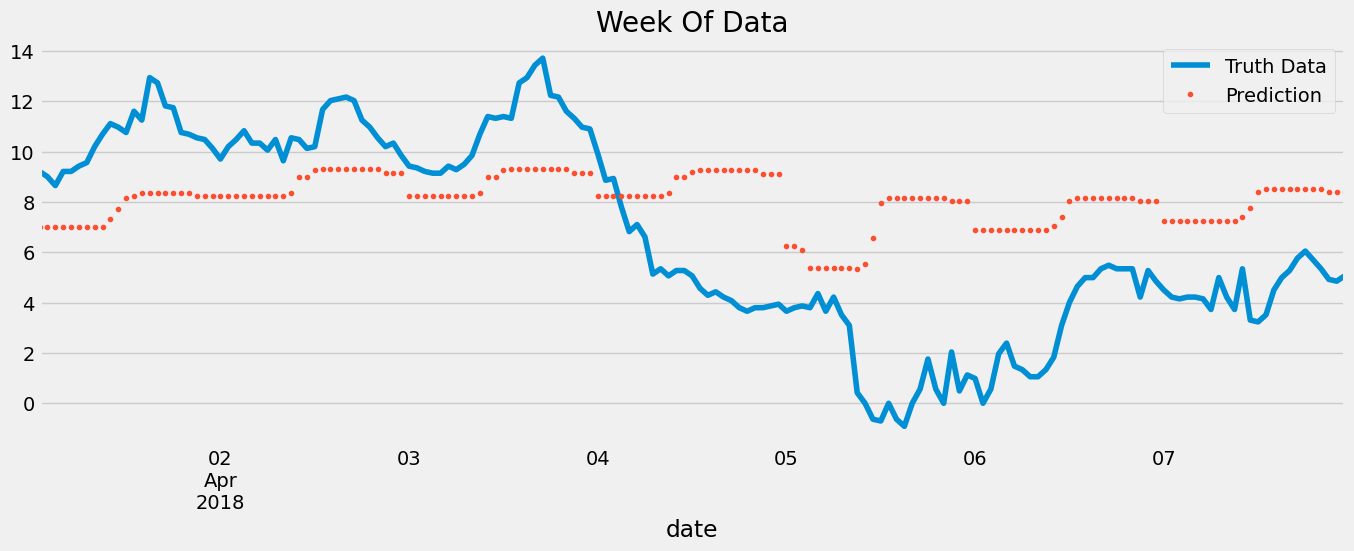

In [13]:
ax = df.loc[(df.index > "04-01-2018") & (df.index < "04-08-2018")]["OT"].plot(
    figsize=(15, 5), title="Week Of Data"
)
df.loc[(df.index > "04-01-2018") & (df.index < "04-08-2018")]["prediction"].plot(
    style="."
)
plt.legend(["Truth Data", "Prediction"])
plt.show()

# Score (RMSE)

In [14]:
score = np.sqrt(mean_squared_error(test["OT"], test["prediction"]))
print(f"RMSE Score on Test set: {score:0.2f}")

RMSE Score on Test set: 3.70


In [15]:
# MSE
mse = mean_squared_error(test["OT"], test["prediction"])
print(f"MSE Score on Test set: {mse:0.2f}")

MSE Score on Test set: 13.72


# Calculate Error
- Look at the worst and best predicted days

In [16]:
test["error"] = np.abs(test[TARGET] - test["prediction"])
test["date"] = test.index.date
test.groupby(["date"])["error"].mean().sort_values(ascending=False).head(10)

ValueError: 'date' is both an index level and a column label, which is ambiguous.

# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)

# The End